In [1]:
import mne
from mne.filter import construct_iir_filter
from mne.preprocessing import annotate_muscle_zscore
from meegkit.asr import ASR

from pipeline.classifier_calib import get_TS_model, get_CSP_model, get_MDM_model, get_kernelTS_model, get_kernelCSP_model

import pyxdf
import numpy as np
from scipy.linalg import sqrtm, inv 
import joblib
import pickle


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from pyriemann.estimation import Covariances
from pyriemann.utils.mean import mean_covariance 

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt    
from autoreject import AutoReject 

In [2]:
def load_raw(fname):
    streams, header = pyxdf.load_xdf(fname)
    for idx, stream in enumerate(streams):
            if stream['info']['type'][0] == 'EEG':
                    eeg_stream = idx
            elif stream['info']['name'][0] == 'MotorImageryMarkers':
                    marker_stream = idx

    data = streams[eeg_stream]["time_series"].T
    #transformation from uV to V
    data[:] *= 1e-6

    # Retrieve the number of channels
    ch_count = int(streams[eeg_stream]['info']['channel_count'][0])
    # Retrieve the channel names
    ch_names = [streams[eeg_stream]['info']['desc'][0]['channels'][0]['channel'][ch_nb]['label'][0] for ch_nb in range(ch_count)]

    # electrode selection
    # list_elect = ["FC1", "Fz", "FC2", "C3", "Cz", "C4", "CP1", "Pz", "CP2"]= [8,4,9,12,13,14,18,24,19]
    if ch_count >9:
        idx_ch = [8,4,9,12,13,14,18,24,19]
        ch_names = np.array(ch_names)[idx_ch]
        ch_count = len(ch_names)
        data = data[idx_ch,:]

    assert data.shape[0] == ch_count  # 8 channels
    sfreq = float(streams[eeg_stream]["info"]["nominal_srate"][0])
    info = mne.create_info(list(ch_names), sfreq, ['eeg'] * ch_count )
    raw = mne.io.RawArray(data, info)
    sfreq = raw.info['sfreq']
    ## Preprocessing
    low_boud = 8
    high_boud=  45
    iir_params = dict(order=30, ftype='butter', output='sos')  
    iir_params = construct_iir_filter(iir_params, f_pass= [low_boud, high_boud], sfreq=sfreq, btype='bandpass', return_copy=True)
    print((2 * len(iir_params['sos']), iir_params['padlen']))
    raw = raw.filter(low_boud, high_boud, method='iir', iir_params=iir_params)
    
    #EEG re-ref
    raw = raw.set_eeg_reference(ref_channels='average')

    # if fname == 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\1605\\true_move.xdf':
    #     tmin = 518
    # else:
    #     tmin = 592 
    
    # asr = ASR(method='euclidean', cutoff=3.5, estimator='lwf', max_dropout_fraction=0.25)
    # baseline = raw.copy().crop(tmin=tmin, tmax=tmin+60).get_data()
    # asr.fit(baseline)
    # cleaned = asr.transform(raw.copy().get_data())
    # raw = mne.io.RawArray(cleaned, info)

    # Load markers
    # get difference between EEG onset and onset of Triggers
    eeg_onset = streams[eeg_stream]["time_stamps"][0] 
    end_idx = len(streams[marker_stream]["time_stamps"]) - 1
    trigger_timestamps = streams[marker_stream]["time_stamps"][:end_idx] - eeg_onset

    # get names of triggers (it's a nested list in the xdf file)    
    # turn nested list into "normal" one dimensional list
    trigger_descriptions = np.array(streams[marker_stream]["time_series"][:end_idx]).astype(int).ravel()

    # save trigger descriptions & their onsets as annotations for our Raw object
    triggers_annot = mne.Annotations(onset = trigger_timestamps, duration = 5., description = trigger_descriptions)

    # The threshold is data dependent, check the optimal threshold by plotting
    #  ``scores_muscle``.
    threshold_muscle = 4  # z-score
    # Choose one channel type, if there are axial gradiometers and magnetometers,
    # # select magnetometers as they are more sensitive to muscle activity.
    annot_muscle, scores_muscle = annotate_muscle_zscore(
    raw,
    ch_type='eeg',
    threshold=threshold_muscle,
    min_length_good=0.2,
    filter_freq=[10, 40],
    )
    # Add trigger annotations to the Raw object that's already containing the EEG data
    raw = raw.set_annotations(triggers_annot + annot_muscle )
    standard_1020 = mne.channels.make_standard_montage("standard_1020")
    raw = raw.set_montage(standard_1020)

    return raw


In [3]:
def preprocess_data(fname):
        raw = load_raw(fname)
        print(raw.ch_names)

        # MI left vs right data
        events, event_id = mne.events_from_annotations(raw, verbose="warning") 
        epochs = mne.Epochs(raw, events, tmin=0.5, tmax=3.5, 
                event_id=event_id, preload=True,  baseline=None) 

        ar = AutoReject(n_jobs=-1, n_interpolate=[0])
        epochs = ar.fit_transform(epochs)
        epochs_MI_stage2 = epochs.get_data(copy=False).astype(np.float64)[:,:,:-1] 
        # epochs_MI_stage2 -= np.mean(epochs_MI_stage2, axis=-1, keepdims=True)
        labels_MI_stage2 = epochs.events[:, -1] - 1  # 0, 1 instead of 1, 2

        # Rebound data
        if '05' in fname:
                tmin = 7.5
                tmax = 10.5
        else:
                tmin = 6.5
                tmax = 9.5
        print(tmin, tmax)
        epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, 
                event_id=event_id, preload=True, baseline=None, verbose = "warning") 
        ar = AutoReject(n_jobs=-1, n_interpolate=[0])
        epochs = ar.fit_transform(epochs)
        # Get rebound epochs and labels
        epochs_rebound = epochs.get_data(copy=False).astype(np.float64)[:,:,:-1]
        # epochs_rebound -= np.mean(epochs_rebound, axis=-1, keepdims=True)
        labels_rebound = np.zeros(len(epochs_rebound)) # Rebound label is 0
        epochs_MI_stage1 = np.copy(epochs_MI_stage2)#[idx]
        labels_MI_stage1 =  np.zeros(len(epochs_MI_stage1)) + 1 # MI label is 1
        # Combine MI and rebound epochs and labels
        combined_epochs = np.concatenate((epochs_MI_stage1, epochs_rebound), axis=0)
        combined_labels = np.concatenate((labels_MI_stage1, labels_rebound), axis=0).astype(int)

        # Euclidean aligment
        cov_matrices = Covariances(estimator='oas').fit_transform(combined_epochs)
        refEA = mean_covariance(cov_matrices, metric='euclid')
        R_inv = sqrtm(inv(refEA))
        combined_epochs = np.einsum('ij,tjk->tik', R_inv, combined_epochs)
        epochs_MI_stage2 = np.einsum('ij,tjk->tik', R_inv, epochs_MI_stage2)
        
        flattened_electrodes = np.abs(combined_epochs).reshape(-1)
        tresh_amp =  np.percentile(flattened_electrodes, 98)
        print(f"Maaax: {np.abs(combined_epochs).reshape(-1).max()}, trheeesh: {tresh_amp}")
        # file = "..\saved_models\\refEA.pickle"
        # with open(file, "wb") as f:
        #         pickle.dump(R_inv, f) 

        return epochs_MI_stage2, labels_MI_stage2, combined_epochs, combined_labels

In [4]:
# fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0516\\true_move.xdf'
# epochs_MI_stage2, labels_MI_stage2, combined_epochs, combined_labels = preprocess_data(fname)

# fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0521\\true_move.xdf'
# epochs_MI_stage2_21, labels_MI_stage2_21, combined_epochs_21, combined_labels_21 = preprocess_data(fname)

fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0716\\calib_biceps.xdf'
epochs_MI_stage2, labels_MI_stage2, combined_epochs, combined_labels = preprocess_data(fname)

fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0718\\calib_biceps.xdf'
epochs_MI_stage2_21, labels_MI_stage2_21, combined_epochs_21, combined_labels_21 = preprocess_data(fname)

fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0516\\true_move.xdf'
epochs_MI_stage2_22, labels_MI_stage2_22, combined_epochs_22, combined_labels_22 = preprocess_data(fname)

fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0521\\true_move.xdf'
epochs_MI_stage2_23, labels_MI_stage2_23, combined_epochs_23, combined_labels_23 = preprocess_data(fname)

fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0916\\calib_arms.xdf'
epochs_MI_stage2_24, labels_MI_stage2_24, combined_epochs_24, combined_labels_24 = preprocess_data(fname)

# file_calib = "..\\saved_models\\ft_data.pickle"
# with open(file_calib, "rb") as f:
#     data_dict = pickle.load(f)
# epochs_MI_stage2_22 = data_dict["calib_data"]*1e-6
# labels_MI_stage2_22 = data_dict["labels"] 

# file_calib = "..\\saved_models\\rebound_ft_data.pickle"
# with open(file_calib, "rb") as f:
#     data_dict = pickle.load(f)
# epochs_rebound = data_dict["calib_data"]*1e-6
# labels_rebound = data_dict["labels"] 


# epochs_MI_stage1 = np.copy(epochs_MI_stage2)#[idx]
# labels_MI_stage1 =  np.zeros(len(epochs_MI_stage1)) + 1 # MI label is 1

# # Combine MI and rebound epochs and labels
# combined_epochs_22 = np.concatenate((epochs_MI_stage1, epochs_rebound), axis=0)
# combined_labels_22 = np.concatenate((labels_MI_stage1, labels_rebound), axis=0).astype(int)

# fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0620\\true_move.xdf'
# epochs_MI_stage2_22, labels_MI_stage2_22, combined_epochs_22, combined_labels_22 = preprocess_data(fname)

# fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0617\\true_move.xdf'
# epochs_MI_stage2_23, labels_MI_stage2_23, combined_epochs_23, combined_labels_23 = preprocess_data(fname)

Creating RawArray with float64 data, n_channels=9, n_times=246030
    Range : 0 ... 246029 =      0.000 ...   984.116 secs
Ready.

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 120 (effective, after forward-backward)
- Cutoffs at 8.00, 45.00 Hz: -6.02, -6.02 dB

(60, 724)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 45 Hz

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
{'eeg': True, 'meg': False}
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passb

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

['FC1', 'Fz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'Pz', 'CP2']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 751 original time points ...
6 bad epochs dropped
Running autoreject on ch_type=eeg


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/54 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/54 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=0


  0%|          | Repairing epochs : 0/54 [00:00<?,       ?it/s]

Dropped 2 epochs: 52, 53
6.5 9.5
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/53 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/53 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=0


  0%|          | Repairing epochs : 0/53 [00:00<?,       ?it/s]

Dropped 2 epochs: 30, 51
Maaax: 8.727125255335217, trheeesh: 2.356637589793406
Creating RawArray with float64 data, n_channels=9, n_times=137640
    Range : 0 ... 137639 =      0.000 ...   550.556 secs
Ready.

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 120 (effective, after forward-backward)
- Cutoffs at 8.00, 45.00 Hz: -6.02, -6.02 dB

(60, 724)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 45 Hz

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
{'eeg': True, 'meg': False}
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/37 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/37 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=0


  0%|          | Repairing epochs : 0/37 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
6.5 9.5
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/34 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/34 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=0


  0%|          | Repairing epochs : 0/34 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Maaax: 13.4106192920966, trheeesh: 2.19727419219399
Creating RawArray with float64 data, n_channels=9, n_times=324150
    Range : 0 ... 324149 =      0.000 ...  1296.596 secs
Ready.

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 120 (effective, after forward-backward)
- Cutoffs at 8.00, 45.00 Hz: -6.02, -6.02 dB

(60, 724)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 45 Hz

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
{'eeg': True, 'meg': False}
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

['FC1', 'Fz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'Pz', 'CP2']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 751 original time points ...
4 bad epochs dropped
Running autoreject on ch_type=eeg


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/56 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/56 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=0


  0%|          | Repairing epochs : 0/56 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
7.5 10.5
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/48 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/48 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.70 and n_interpolate=0


  0%|          | Repairing epochs : 0/48 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Maaax: 7.998492219531554, trheeesh: 2.231522775977079
Creating RawArray with float64 data, n_channels=9, n_times=408650
    Range : 0 ... 408649 =      0.000 ...  1634.596 secs
Ready.

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 120 (effective, after forward-backward)
- Cutoffs at 8.00, 45.00 Hz: -6.02, -6.02 dB

(60, 724)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 45 Hz

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
{'eeg': True, 'meg': False}
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pas

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

['FC1', 'Fz', 'FC2', 'C3', 'Cz', 'C4', 'CP1', 'Pz', 'CP2']
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 751 original time points ...
3 bad epochs dropped
Running autoreject on ch_type=eeg


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/57 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/57 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=0


  0%|          | Repairing epochs : 0/57 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
7.5 10.5
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/47 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/47 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=0


  0%|          | Repairing epochs : 0/47 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Maaax: 17.24064946737115, trheeesh: 2.2356687930219845
Creating RawArray with float64 data, n_channels=9, n_times=113400
    Range : 0 ... 113399 =      0.000 ...   453.596 secs
Ready.

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 120 (effective, after forward-backward)
- Cutoffs at 8.00, 45.00 Hz: -6.02, -6.02 dB

(60, 724)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 45 Hz

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
{'eeg': True, 'meg': False}
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pa

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/27 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/27 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=0


  0%|          | Repairing epochs : 0/27 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
6.5 9.5
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/9 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/9 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/28 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/1 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/28 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=0


  0%|          | Repairing epochs : 0/28 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Maaax: 5.980473308248056, trheeesh: 2.2166027161186506


## Gather data from two different sessions

In [5]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [6]:
print(combined_epochs.shape, combined_epochs_21.shape)
print(epochs_MI_stage2.shape, epochs_MI_stage2_21.shape)

combined_epochs = np.concatenate((combined_epochs, combined_epochs_21, combined_epochs_22, combined_epochs_23, combined_epochs_24), axis=0) #, combined_epochs_22, combined_epochs_23
combined_labels = np.concatenate((combined_labels, combined_labels_21, combined_labels_22, combined_labels_23, combined_labels_24), axis=0) # , combined_labels_22,combined_labels_23


epochs_MI_stage2 = np.concatenate((epochs_MI_stage2, epochs_MI_stage2_21, epochs_MI_stage2_22, epochs_MI_stage2_23, epochs_MI_stage2_24), axis=0) # , epochs_MI_stage2_22, epochs_MI_stage2_23
labels_MI_stage2 = np.concatenate((labels_MI_stage2, labels_MI_stage2_21, labels_MI_stage2_22, labels_MI_stage2_23, labels_MI_stage2_24), axis=0) # , labels_MI_stage2_22, labels_MI_stage2_23

epochs_MI_stage2, labels_MI_stage2 = unison_shuffled_copies(epochs_MI_stage2, labels_MI_stage2)
combined_epochs, combined_labels = unison_shuffled_copies(combined_epochs, combined_labels)
print(combined_epochs.shape)
print(epochs_MI_stage2.shape)

(103, 9, 750) (71, 9, 750)
(52, 9, 750) (37, 9, 750)
(437, 9, 750)
(229, 9, 750)


In [7]:
# Function to under-sample the majority class
def undersample_data(epochs, labels):
    # Separate the classes
    class_0_indices = np.where(labels == 0)[0]
    class_1_indices = np.where(labels == 1)[0]
    
    # Determine the smaller class size
    min_class_size = min(len(class_0_indices), len(class_1_indices))
    
    # Randomly sample from both classes
    np.random.seed(42)  # For reproducibility
    undersampled_class_0_indices = np.random.choice(class_0_indices, min_class_size, replace=False)
    undersampled_class_1_indices = np.random.choice(class_1_indices, min_class_size, replace=False)
    
    # Combine the sampled indices
    undersampled_indices = np.concatenate([undersampled_class_0_indices, undersampled_class_1_indices])
    
    # Shuffle the indices to mix class samples
    np.random.shuffle(undersampled_indices)
    
    # Extract the undersampled data and labels
    undersampled_epochs = epochs[undersampled_indices]
    undersampled_labels = labels[undersampled_indices]
    
    return undersampled_epochs, undersampled_labels


In [8]:
print(f'Original dataset size: {epochs_MI_stage2.shape[0]} trials')
epochs_MI_stage2, labels_MI_stage2 = undersample_data(epochs_MI_stage2, labels_MI_stage2)
print(f'Balanced dataset size: {epochs_MI_stage2.shape[0]} trials')
print(f'Class distribution in balanced dataset: {np.bincount(labels_MI_stage2)}')

print(f'Original dataset size: {combined_epochs.shape[0]} trials')
combined_epochs, combined_labels = undersample_data(combined_epochs, combined_labels)
print(f'Balanced dataset size: {combined_epochs.shape[0]} trials')
print(f'Class distribution in balanced dataset: {np.bincount(combined_labels)}')
   

Original dataset size: 229 trials
Balanced dataset size: 228 trials
Class distribution in balanced dataset: [114 114]
Original dataset size: 437 trials
Balanced dataset size: 416 trials
Class distribution in balanced dataset: [208 208]


In [9]:
data_dict = {"calib_data": np.squeeze(np.array(epochs_MI_stage2)), "labels": labels_MI_stage2}
file_calib = "..\\saved_models\\calib_data.pickle"
with open(file_calib, "wb") as f:
    pickle.dump(data_dict, f)
data_dict = {"calib_data": np.array(combined_epochs), "labels": combined_labels}
file = "..\\saved_models\\rebound_data.pickle"
with open(file, "wb") as f:
    pickle.dump(data_dict, f)

## Train models

In [10]:
model, search_space = get_MDM_model()
cov = model['feat'].fit_transform(combined_epochs)
model['classifier'].fit(cov, combined_labels)
dist = model['classifier'].transform(cov)

tresh = np.percentile(dist[combined_labels==1, 1], 99)

file = f'..\\saved_models\\tresh_M1.pickle'
with open(file, "wb") as f:
    pickle.dump(tresh, f)

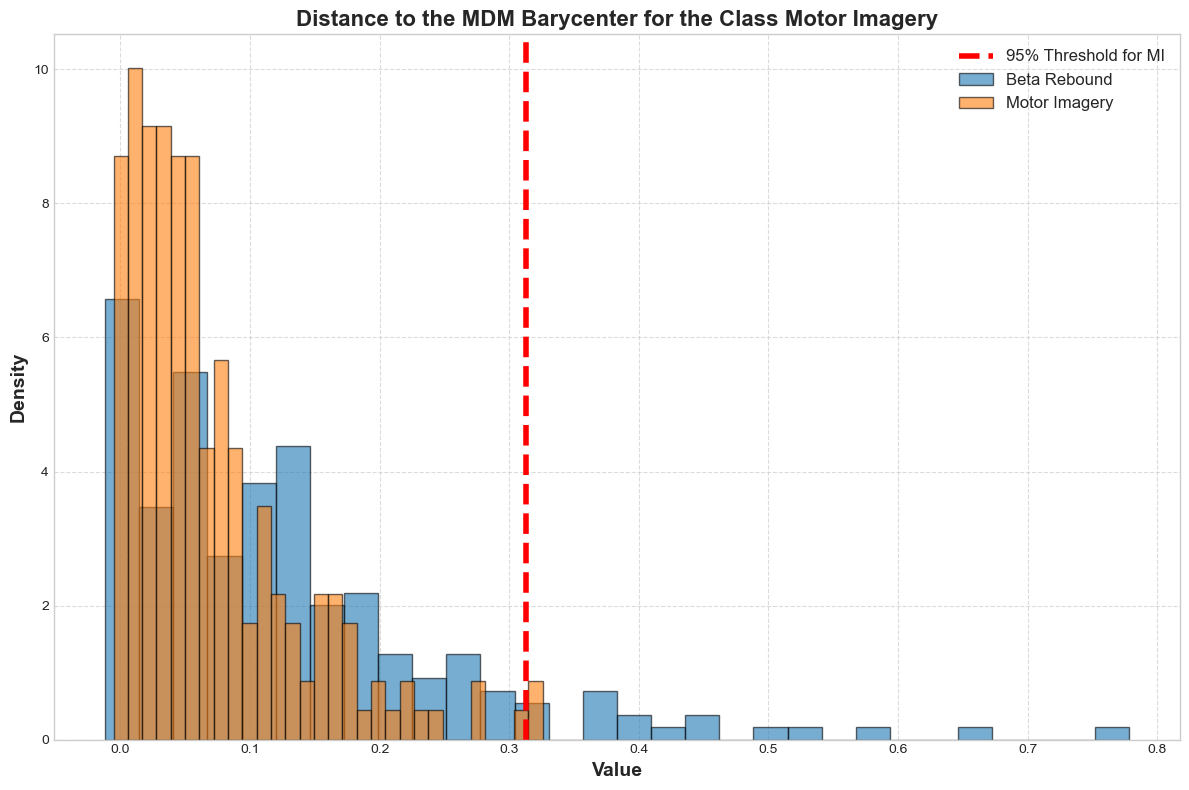

In [11]:
%matplotlib inline
# Compute the histogram for the rebound class
counts, bins = np.histogram(dist[combined_labels == 0, 1], bins=30)
bin_width = bins[1] - bins[0]
density = counts / (len(dist[combined_labels == 0, 1]) * bin_width)

# Calculate the histogram for the MI class
counts1, bins1 = np.histogram(dist[combined_labels == 1, 1], bins=30)
bin_width1 = bins1[1] - bins1[0]
density1 = counts1 / (len(dist[combined_labels == 1, 1]) * bin_width1)

# Use a modern style
plt.style.use('seaborn-v0_8-whitegrid')

# Create the plot
plt.figure(figsize=(12, 8))  # Set the figure size

# Color palette
colors = ['#1f77b4', '#ff7f0e']

# Plot histograms with transparency for overlapping bars
plt.bar(bins[:-1], density, width=bin_width, edgecolor='black', color=colors[0], alpha=0.6, label='Beta Rebound')
plt.bar(bins1[:-1], density1, width=bin_width1, edgecolor='black', color=colors[1], alpha=0.6, label='Motor Imagery')

# Add a vertical line for the threshold
plt.axvline(x=tresh, color='red', linewidth=4, linestyle='--', ymax=1, label='95% Threshold for MI')

# Add titles and labels
plt.title('Distance to the MDM Barycenter for the Class Motor Imagery', fontsize=16, fontweight='bold')
plt.xlabel('Value', fontsize=14, fontweight='bold')
plt.ylabel('Density', fontsize=14, fontweight='bold')

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots
plt.show()

## MDM for stage 1 + TS-LR for stage 2

In [12]:

results = {}

Training the model...


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_param

**************************************************
0.63 accuracy with a standard deviation of 0.02
**************************************************


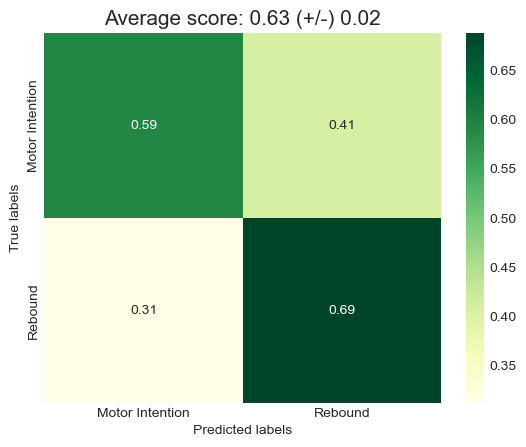

<Figure size 640x480 with 0 Axes>

In [13]:
model, search_space = get_MDM_model()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=search_space, cv=cv, n_jobs=-1)
print("Training the model...")
grid.fit(combined_epochs, combined_labels)

clf = grid.best_estimator_
print('*'*50)
# Get the mean and std of the test scores for the best parameters
scores = cross_val_score(clf, combined_epochs, combined_labels, cv=7)
# Print the results
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print('*'*50)
y_pred = cross_val_predict(clf, combined_epochs, combined_labels, cv=5)
conf_mat = confusion_matrix(combined_labels, y_pred)
# Normalize
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
ax= plt.subplot()
cmn = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(cmn, annot=True ,cmap="YlGn", ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
classes_names = ['Motor Intention','Rebound']
ax.xaxis.set_ticklabels(classes_names); ax.yaxis.set_ticklabels(classes_names)
plt.title(f'Average score: {scores.mean():.2f} (+/-) {scores.std():.2f}', fontsize = 15)
file = f'..\\saved_models\\MDM_stage1.pickle'
joblib.dump(grid, file)
plt.show()
plt.savefig("..\\saved_models\MDM_stage1.png")

Training the model...


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
 

**************************************************
Second stage accuracy: 50.31% +/- 6.81
**************************************************


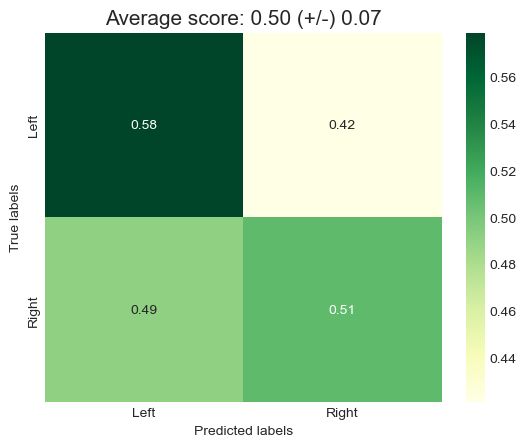

<Figure size 640x480 with 0 Axes>

In [14]:
# model, search_space = get_kernelTS_model(reg='oas', metric='euclid', kernels=np.array(conv_kernels))
model, search_space = get_TS_model(reg='oas')
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=search_space, cv=cv, n_jobs=-1)
print("Training the model...")
grid.fit(epochs_MI_stage2, labels_MI_stage2)

clf = grid.best_estimator_
print('*'*50)
# Get the mean and std of the test scores for the best parameters
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=4, random_state=42)
scores = cross_val_score(clf, epochs_MI_stage2, labels_MI_stage2, cv=cv)
# Print the results
print("Second stage accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))
print('*'*50)

y_pred = cross_val_predict(clf, epochs_MI_stage2, labels_MI_stage2, cv=5)
conf_mat = confusion_matrix(labels_MI_stage2, y_pred)
# Normalise
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
ax= plt.subplot()
cmn = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(cmn, annot=True ,cmap="YlGn", ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
classes_names = ['Left','Right']
ax.xaxis.set_ticklabels(classes_names); ax.yaxis.set_ticklabels(classes_names)
plt.title(f'Average score: {scores.mean():.2f} (+/-) {scores.std():.2f}', fontsize = 15)
plt.show()
file = f'..\\saved_models\\TS_stage2.pickle'
joblib.dump(grid, file)
plt.show()
plt.savefig("..\\saved_models\TS_stage2.png")

results['tangentspace_nokernel'] = [scores.mean(), scores.std()]

Training the model...


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**************************************************


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Second stage accuracy: 51.33% +/- 7.62
**************************************************


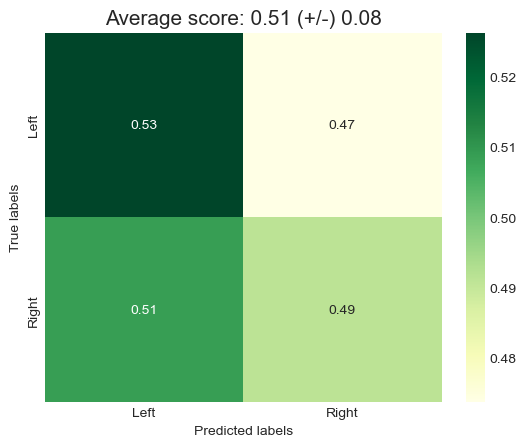

<Figure size 640x480 with 0 Axes>

In [15]:
data = "2014001"
kernels = np.load(f"C:\\Users\\ludov\\Documents\\repos\\kernelsConstruction\\extra_kernels\\kernels_{data}.npy", allow_pickle=True).tolist()
kernels = np.array(kernels)[[0,1,3,6,7]]#[[2,3,5,6,7]]
model, search_space = get_kernelTS_model(reg='oas', metric='euclid', kernels=kernels)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=search_space, cv=cv, n_jobs=-1)
print("Training the model...")
grid.fit(epochs_MI_stage2, labels_MI_stage2)

clf = grid.best_estimator_
print('*'*50)
# Get the mean and std of the test scores for the best parameters
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=4, random_state=42)
scores = cross_val_score(clf, epochs_MI_stage2, labels_MI_stage2, cv=cv)
# Print the results
print("Second stage accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))
print('*'*50)

y_pred = cross_val_predict(clf, epochs_MI_stage2, labels_MI_stage2, cv=5)
conf_mat = confusion_matrix(labels_MI_stage2, y_pred)
# Normalise
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
ax= plt.subplot()
cmn = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(cmn, annot=True ,cmap="YlGn", ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
classes_names = ['Left','Right']
ax.xaxis.set_ticklabels(classes_names); ax.yaxis.set_ticklabels(classes_names)
plt.title(f'Average score: {scores.mean():.2f} (+/-) {scores.std():.2f}', fontsize = 15)
file = f'..\\saved_models\\kernelTS_stage2.pickle'
joblib.dump(grid, file)
plt.show()
plt.savefig("..\\saved_models\kernelTS_stage2.png")


results['tangentspace_kernels2014001'] = [scores.mean(), scores.std()]

Training the model...
**************************************************
Second stage accuracy: 51.88% +/- 7.44
**************************************************


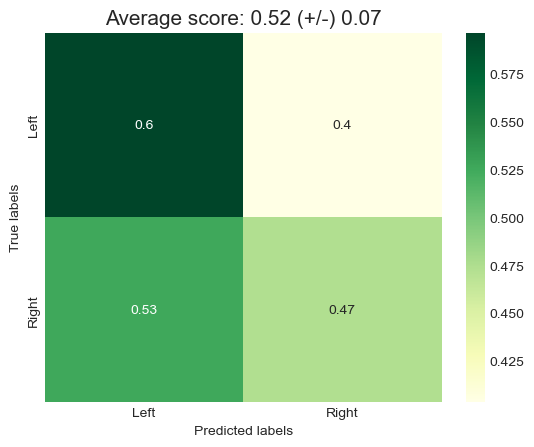

In [16]:
data = "2014004"
kernels = np.load(f"C:\\Users\\ludov\\Documents\\repos\\kernelsConstruction\\extra_kernels\\kernels_{data}.npy", allow_pickle=True).tolist()
kernels = np.array(kernels)[[2,3,5,6,7]]
model, search_space = get_kernelTS_model(reg='oas', metric='euclid', kernels=kernels)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=search_space, cv=cv, n_jobs=-1)
print("Training the model...")
grid.fit(epochs_MI_stage2, labels_MI_stage2)

clf = grid.best_estimator_
print('*'*50)
# Get the mean and std of the test scores for the best parameters
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=4, random_state=42)
scores = cross_val_score(clf, epochs_MI_stage2, labels_MI_stage2, cv=cv)
# Print the results
print("Second stage accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))
print('*'*50)

y_pred = cross_val_predict(clf, epochs_MI_stage2, labels_MI_stage2, cv=5)
conf_mat = confusion_matrix(labels_MI_stage2, y_pred)
# Normalise
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
ax= plt.subplot()
cmn = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(cmn, annot=True ,cmap="YlGn", ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
classes_names = ['Left','Right']
ax.xaxis.set_ticklabels(classes_names); ax.yaxis.set_ticklabels(classes_names)
plt.title(f'Average score: {scores.mean():.2f} (+/-) {scores.std():.2f}', fontsize = 15)

results['tangentspace_kernels2014004'] = [scores.mean(), scores.std()]

Training the model...


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**************************************************


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Second stage accuracy: 58.90% +/- 8.77
**************************************************


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

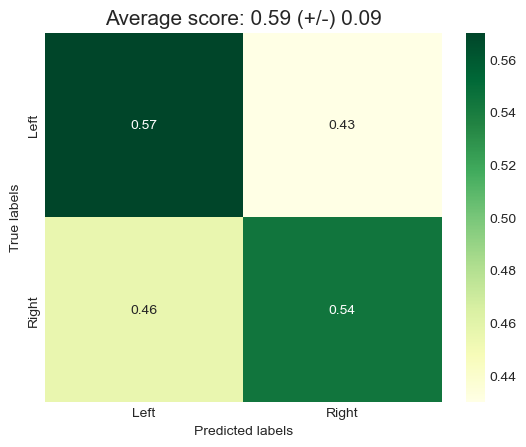

In [17]:
kernels = np.load(f"C:\\Users\\ludov\\Documents\\repos\\kernelsConstruction\\extra_kernels\\kernels.npy", allow_pickle=True).tolist()
model, search_space = get_kernelTS_model(reg='oas', metric='euclid', kernels=kernels)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=search_space, cv=cv, n_jobs=-1)
print("Training the model...")
grid.fit(epochs_MI_stage2, labels_MI_stage2)

clf = grid.best_estimator_
print('*'*50)
# Get the mean and std of the test scores for the best parameters
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=4, random_state=42)
scores = cross_val_score(clf, epochs_MI_stage2, labels_MI_stage2, cv=cv)
# Print the results
print("Second stage accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))
print('*'*50)

y_pred = cross_val_predict(clf, epochs_MI_stage2, labels_MI_stage2, cv=5)
conf_mat = confusion_matrix(labels_MI_stage2, y_pred)
# Normalise
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
ax= plt.subplot()
cmn = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(cmn, annot=True ,cmap="YlGn", ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
classes_names = ['Left','Right']
ax.xaxis.set_ticklabels(classes_names); ax.yaxis.set_ticklabels(classes_names)
plt.title(f'Average score: {scores.mean():.2f} (+/-) {scores.std():.2f}', fontsize = 15)

results['tangentspace_kernelslucas'] = [scores.mean(), scores.std()]

## EA computation

fname = 'C:\\Users\\ludov\\Documents\\pre_tests\\S1\\0625\\game.xdf'

streams, header = pyxdf.load_xdf(fname)
for idx, stream in enumerate(streams):
        if stream['info']['type'][0] == 'EEG':
                eeg_stream = idx
        elif stream['info']['name'][0] == 'MotorImageryMarkers':
                marker_stream = idx

data = streams[eeg_stream]["time_series"].T
#transformation from uV to V
data[:] *= 1e-6

# Retrieve the number of channels
ch_count = int(streams[eeg_stream]['info']['channel_count'][0])
# Retrieve the channel names
ch_names = [streams[eeg_stream]['info']['desc'][0]['channels'][0]['channel'][ch_nb]['label'][0] for ch_nb in range(ch_count)]

# electrode selection
# list_elect = ["FC1", "Fz", "FC2", "C3", "Cz", "C4", "CP1", "Pz", "CP2"]= [8,4,9,12,13,14,18,24,19]
if ch_count >9:
    idx_ch = [8,4,9,12,13,14,18,24,19]
    ch_names = np.array(ch_names)[idx_ch]
    ch_count = len(ch_names)
    data = data[idx_ch,:]

assert data.shape[0] == ch_count  # 8 channels
sfreq = float(streams[eeg_stream]["info"]["nominal_srate"][0])
info = mne.create_info(list(ch_names), sfreq, ['eeg'] * ch_count )
raw = mne.io.RawArray(data, info)
sfreq = raw.info['sfreq']
## Preprocessing
low_boud = 5
high_boud=  48
iir_params = dict(order=30, ftype='butter', output='sos')  
iir_params = construct_iir_filter(iir_params, f_pass= [low_boud, high_boud], sfreq=sfreq, btype='bandpass', return_copy=True)
print((2 * len(iir_params['sos']), iir_params['padlen']))
raw = raw.filter(low_boud, high_boud, method='iir', iir_params=iir_params)
raw = raw.set_eeg_reference(ref_channels='average')

standard_1020 = mne.channels.make_standard_montage("standard_1020")
raw = raw.set_montage(standard_1020)

epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=False)
epochs_data = epochs.get_data()

cov_matrices = Covariances(estimator='oas').fit_transform(epochs_data[5:45])
refEA = mean_covariance(cov_matrices, metric='euclid')
R_inv = sqrtm(inv(refEA))
epochs_data = np.einsum("ij,tjk->tik", R_inv, epochs_data)
file = "..\saved_models\\refEA.pickle"
with open(file, "wb") as f:
        pickle.dump(R_inv, f) 

## CSP for stage 1 + CSP for stage 2

Training the model...


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
 

**************************************************
0.59 accuracy with a standard deviation of 0.06
**************************************************


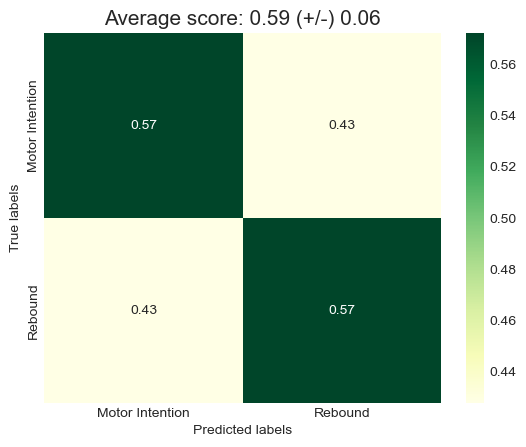

<Figure size 640x480 with 0 Axes>

In [18]:
model, search_space = get_CSP_model()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=search_space, cv=cv, n_jobs=-1)
print("Training the model...")
grid.fit(combined_epochs, combined_labels)

clf = grid.best_estimator_
print('*'*50)
# Get the mean and std of the test scores for the best parameters
scores = cross_val_score(clf, combined_epochs, combined_labels, cv=7)
# Print the results
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print('*'*50)
y_pred = cross_val_predict(clf, combined_epochs, combined_labels, cv=5)
conf_mat = confusion_matrix(combined_labels, y_pred)
# Normalize
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
ax= plt.subplot()
cmn = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(cmn, annot=True ,cmap="YlGn", ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
classes_names = ['Motor Intention','Rebound']
ax.xaxis.set_ticklabels(classes_names); ax.yaxis.set_ticklabels(classes_names)
plt.title(f'Average score: {scores.mean():.2f} (+/-) {scores.std():.2f}', fontsize = 15)
file = f'..\\saved_models\\CSP_stage1.pickle'
joblib.dump(grid, file)
plt.show()
plt.savefig("..\\saved_models\CSP_stage1.png")

Training the model...


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
 

**************************************************
Second stage accuracy: 48.48% +/- 7.54
**************************************************


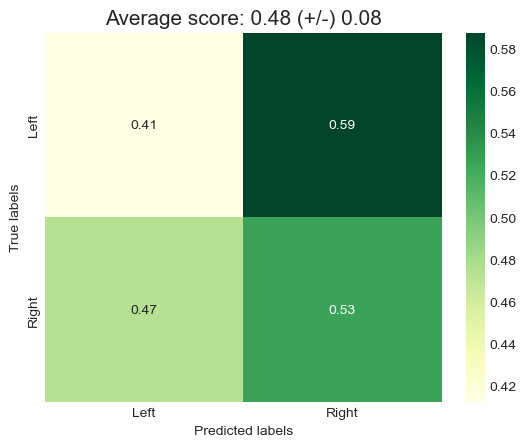

<Figure size 640x480 with 0 Axes>

In [19]:
model, search_space = get_CSP_model()
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(model, param_grid=search_space, cv=cv, n_jobs=-1)
print("Training the model...")
grid.fit(epochs_MI_stage2.astype(np.float64), labels_MI_stage2)

clf = grid.best_estimator_
print('*'*50)
# Get the mean and std of the test scores for the best parameters
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=4, random_state=42)
scores = cross_val_score(clf, epochs_MI_stage2.astype(np.float64), labels_MI_stage2, cv=cv)
# Print the results
print("Second stage accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))
print('*'*50)

y_pred = cross_val_predict(clf, epochs_MI_stage2, labels_MI_stage2, cv=5)
conf_mat = confusion_matrix(labels_MI_stage2, y_pred)
# Normalise
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
ax= plt.subplot()
cmn = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(cmn, annot=True ,cmap="YlGn", ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
classes_names = ['Left','Right']
ax.xaxis.set_ticklabels(classes_names); ax.yaxis.set_ticklabels(classes_names)
plt.title(f'Average score: {scores.mean():.2f} (+/-) {scores.std():.2f}', fontsize = 15)
file = f'..\\saved_models\\CSP_stage2.pickle'
joblib.dump(grid, file)
plt.show()
plt.savefig("..\\saved_models\CSP_stage2.png")

results['csp_nokernels'] = [scores.mean(), scores.std()]

Training the model...


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
 

**************************************************


c:\Users\ludov\Documents\repos\MIonline\classification\pipeline\csp.py:103: RuntimeWarning: invalid value encountered in matmul
  cov_avg[c1] @ U - cov_avg[c2] @ U @ np.diag(eig_vals),
c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\numpy\core\numeric.py:2387: RuntimeWarning: invalid value encountered in multiply
  x = x * ones_like(cond)
c:\Users\ludov\Documents\repos\MIonline\classification\pipeline\csp.py:103: RuntimeWarning: invalid value encountered in matmul
  cov_avg[c1] @ U - cov_avg[c2] @ U @ np.diag(eig_vals),
c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\numpy\core\numeric.py:2387: RuntimeWarning: invalid value encountered in multiply
  x = x * ones_like(cond)
c:\Users\ludov\Documents\repos\MIonline\classification\pipeline\csp.py:103: RuntimeWarning: invalid value encountered in matmul
  cov_avg[c1] @ U - cov_avg[c2] @ U @ np.diag(eig_vals),
c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\numpy\core\numeric.py:2387: RuntimeWarning: invalid value encountered in mul

Second stage accuracy: nan% +/- nan
**************************************************


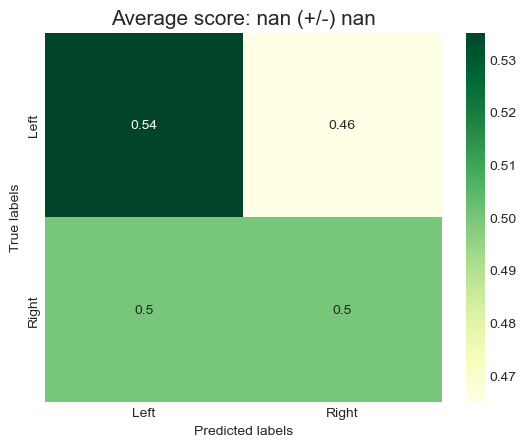

In [20]:
kernels = np.load(f"C:\\Users\\ludov\\Documents\\repos\\kernelsConstruction\\extra_kernels\\kernels.npy", allow_pickle=True)
# kernels = kernels.reshape((6,-1))
model, search_space = get_kernelCSP_model(kernels=kernels)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=12)
grid = GridSearchCV(model, param_grid=search_space, cv=cv, n_jobs=-1)
print("Training the model...")
grid.fit(epochs_MI_stage2.astype(np.float64), labels_MI_stage2)

clf = grid.best_estimator_
print('*'*50)
# Get the mean and std of the test scores for the best parameters
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=4, random_state=42)
scores = cross_val_score(clf, epochs_MI_stage2.astype(np.float64), labels_MI_stage2, cv=cv)
# Print the results
print("Second stage accuracy: {:.2f}% +/- {:.2f}".format(np.mean(scores)*100,
                                                np.std(scores)*100))
print('*'*50)

y_pred = cross_val_predict(clf, epochs_MI_stage2, labels_MI_stage2, cv=5)
conf_mat = confusion_matrix(labels_MI_stage2, y_pred)
# Normalise
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# Plot confusion matrix
ax= plt.subplot()
cmn = pd.DataFrame(conf_mat, range(2), range(2))
sns.heatmap(cmn, annot=True ,cmap="YlGn", ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
classes_names = ['Left','Right']
ax.xaxis.set_ticklabels(classes_names); ax.yaxis.set_ticklabels(classes_names)
plt.title(f'Average score: {scores.mean():.2f} (+/-) {scores.std():.2f}', fontsize = 15)
file = f'..\\saved_models\\kernelCSP_stage2.pickle'
joblib.dump(grid, file)
plt.savefig("..\\saved_models\confusion_matrix_kernelsCSPHaffed_stage2.png")
results['csp_kernelslucas'] = [scores.mean(), scores.std()]

## Plot comparisons

In [21]:
results

{'tangentspace_nokernel': [0.5031452922077922, 0.06811181808453129],
 'tangentspace_kernels2014001': [0.5133252164502164, 0.07619552145222583],
 'tangentspace_kernels2014004': [0.5188041125541126, 0.0744392506647396],
 'tangentspace_kernelslucas': [0.5890489718614719, 0.08771453358751334],
 'csp_nokernels': [0.48481466450216454, 0.07540268018211159],
 'csp_kernelslucas': [nan, nan]}

In [22]:
df = pd.DataFrame(results)
df.head()

,tangentspace_nokernel,tangentspace_kernels2014001,tangentspace_kernels2014004,tangentspace_kernelslucas,csp_nokernels,csp_kernelslucas
0,0.503145,0.513325,0.518804,0.589049,0.484815,NaN
1,0.068112,0.076196,0.074439,0.087715,0.075403,NaN


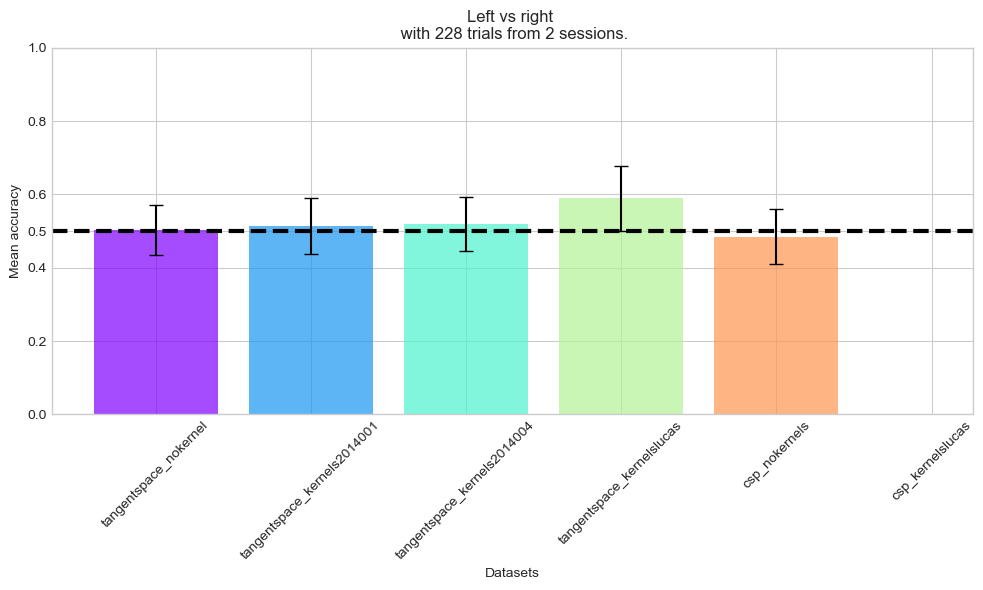

In [23]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(results)))
means = df.iloc[0]
stds = df.iloc[1]

plt.figure(figsize=(10, 6))
plt.bar(means.index, means.values, yerr=stds.values, capsize=5, alpha=0.7, color=colors)
plt.xlabel('Datasets')
plt.ylabel('Mean accuracy')
plt.title(f'Left vs right \n with {len(epochs_MI_stage2)} trials from 2 sessions.')
plt.xticks(rotation=45)
plt.yticks([0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0])
plt.axhline(y=0.5, linewidth=3, color='k', linestyle='--')
plt.tight_layout()

## Explore rebound data

In [24]:
file_calib = "..\\saved_models\\rebound_data.pickle"
with open(file_calib, "rb") as f:
    data_dict = pickle.load(f)
X = data_dict["calib_data"]*1e-6
y = data_dict["labels"] 
samples = X.shape[2]
n_trials = X.shape[0]


In [25]:
sfreq = 250  # Sampling frequency in Hz
ch_names =["FC1", "Fz", "FC2", "C3", "Cz", "C4", "CP1", "Pz", "CP2"]  # Channel names
ch_types = ['eeg'] * len(ch_names)  # Channel types (all EEG in this example)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

events = np.array([[i * samples, 0, int(y[i])] for i in range(n_trials)])
event_id = {'rebound': 0, 'MI':1}
epochs = mne.EpochsArray(X, info, events=events, event_id=event_id)
standard_1020 = mne.channels.make_standard_montage("standard_1020")
epochs = epochs.set_montage(standard_1020)
epochs = epochs['rebound']

Not setting metadata
416 matching events found
No baseline correction applied
0 projection items activated


Using matplotlib as 2D backend.


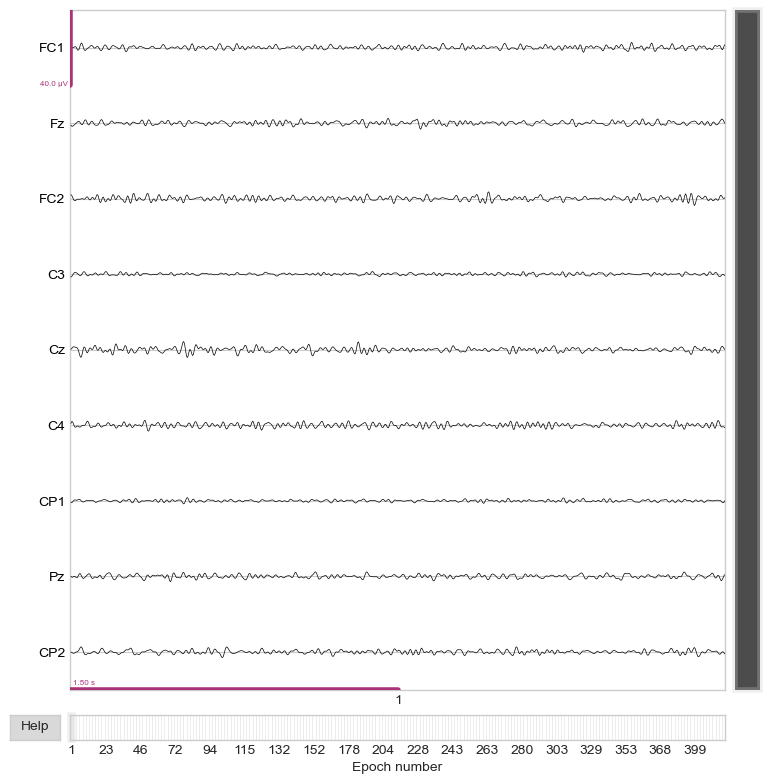

In [26]:
#%matplotlib widget
epochs.plot(n_epochs=1);

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


c:\Users\ludov\.conda\envs\MIBCI\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


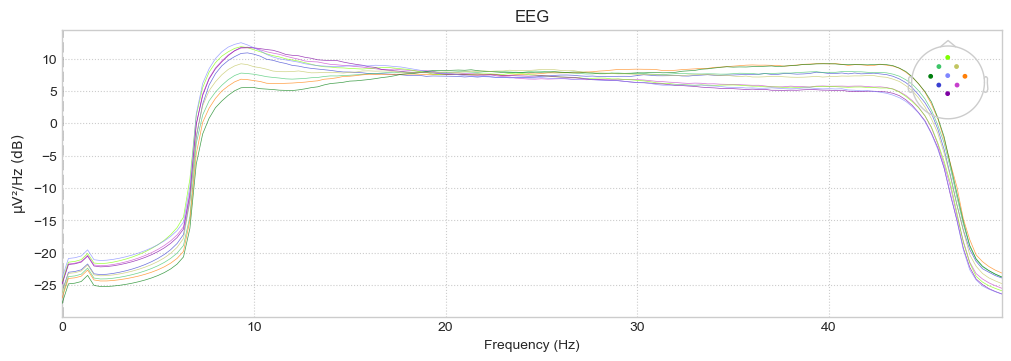

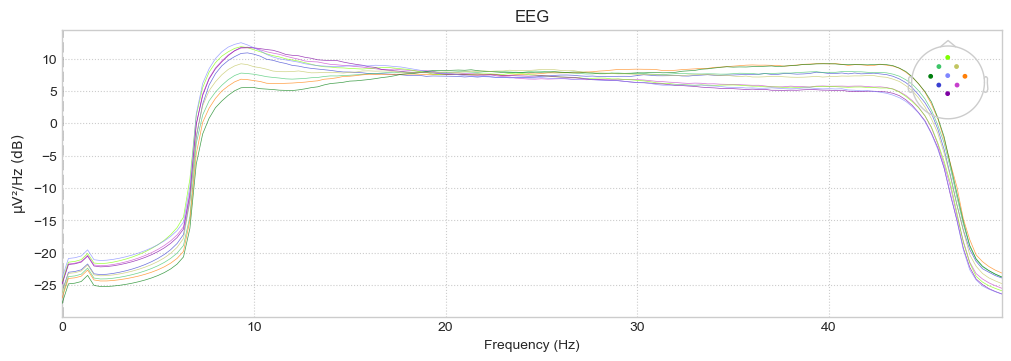

In [27]:
spectrum = epochs.compute_psd(fmax=49 )
spectrum.plot(average=False, picks="data", exclude="bads", amplitude=False)

In [28]:
from sklearn.manifold import spectral_embedding  # noqa
from sklearn.metrics.pairwise import rbf_kernel  # noqa


def order_func(times, data):
    this_data = data[:, (times > 0.0) & (times < 0.350)]
    this_data /= np.sqrt(np.sum(this_data**2, axis=1))[:, np.newaxis]
    return np.argsort(
        spectral_embedding(
            rbf_kernel(this_data, gamma=1.0), n_components=1, random_state=0
        ).ravel()
    )

plt_times = np.linspace(0, 0.2, len(epochs))

In [29]:
c3 = np.where(np.array(epochs.ch_names) == "C3")[0][0]
c4 = np.where(np.array(epochs.ch_names) == "C4")[0][0]
cz = np.where(np.array(epochs.ch_names) == "Cz")[0][0]
cp1 = np.where(np.array(epochs.ch_names) == "CP1")[0][0]
cp2 = np.where(np.array(epochs.ch_names) == "CP2")[0][0]

Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated


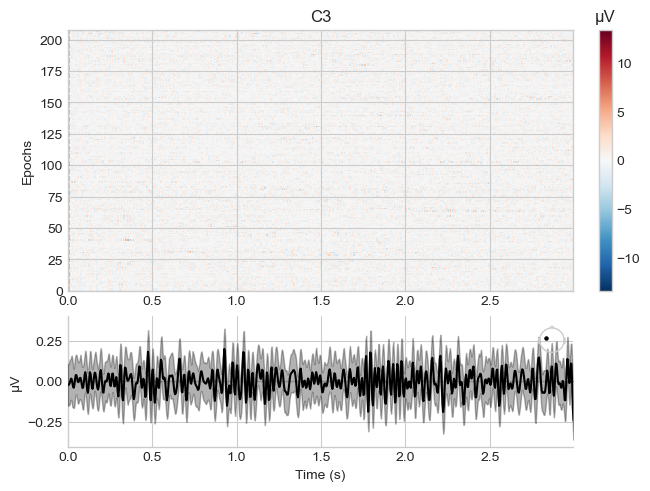

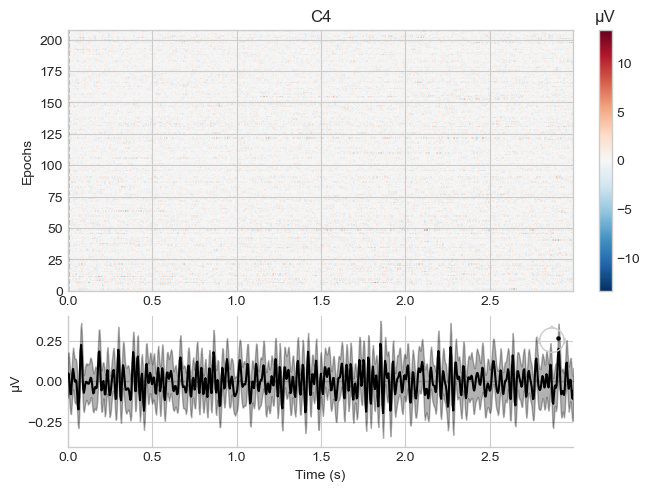

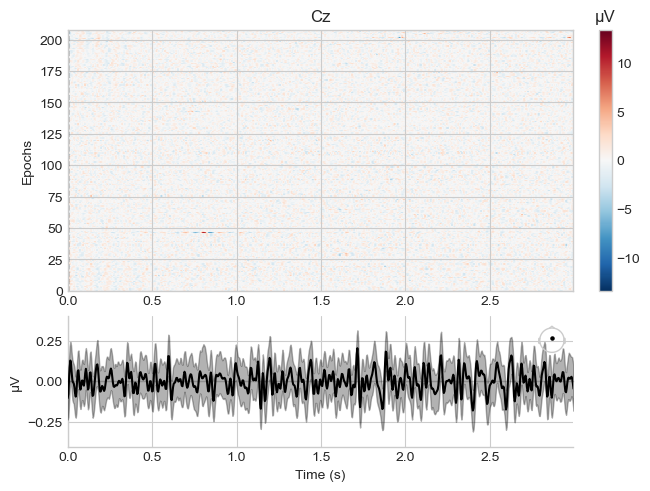

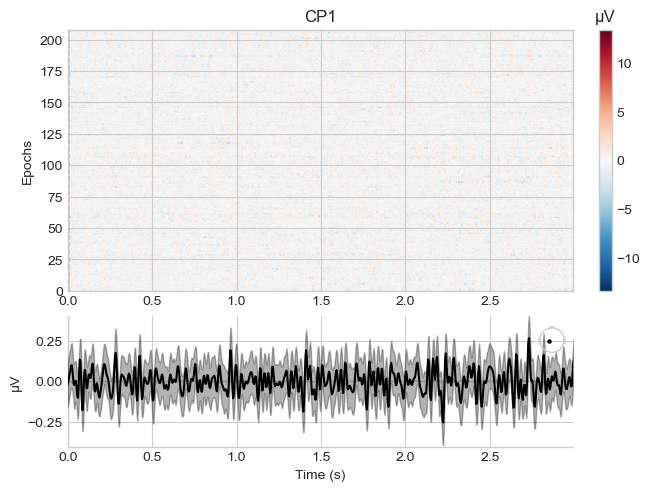

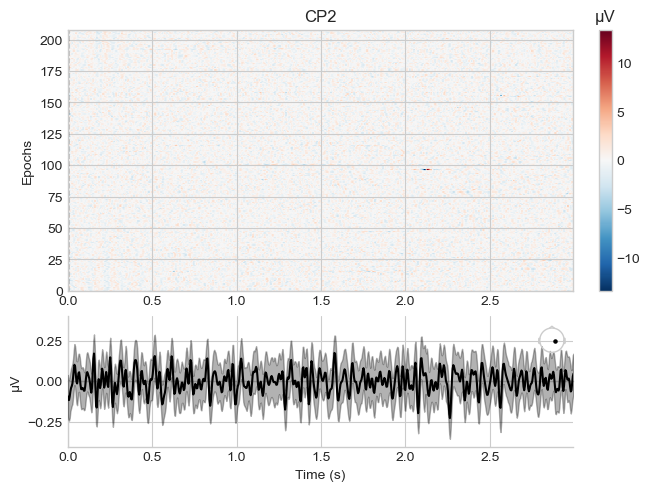

[<Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>,
 <Figure size 640x480 with 4 Axes>]

In [30]:
mne.viz.plot_epochs_image(
    epochs,
    [c3,c4,cz,cp1,cp2],
    sigma=0.5,
    order=order_func,
    #vmin=-250,
    #vmax=250,
    #overlay_times=plt_times,
    show=True,
)

In [31]:
from mne.time_frequency import tfr_multitaper, tfr_morlet

freqs =np.linspace(5, 48, num=60)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.1s finished


Applying baseline correction (mode: logratio)


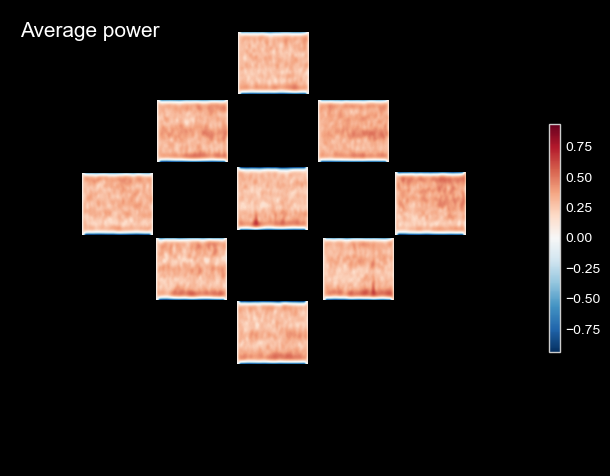

Applying baseline correction (mode: logratio)


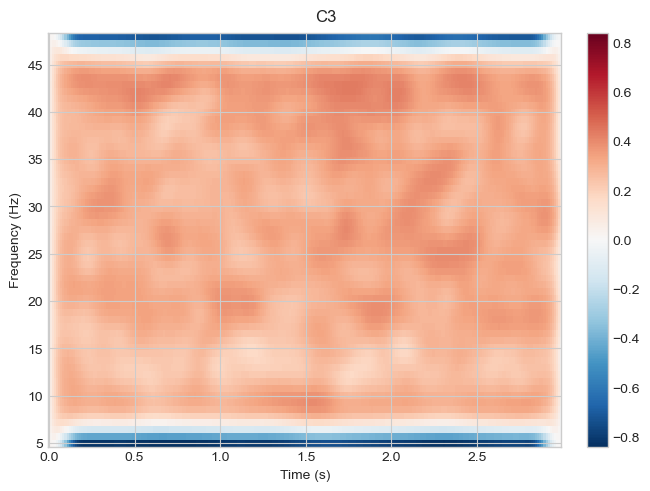

Applying baseline correction (mode: logratio)


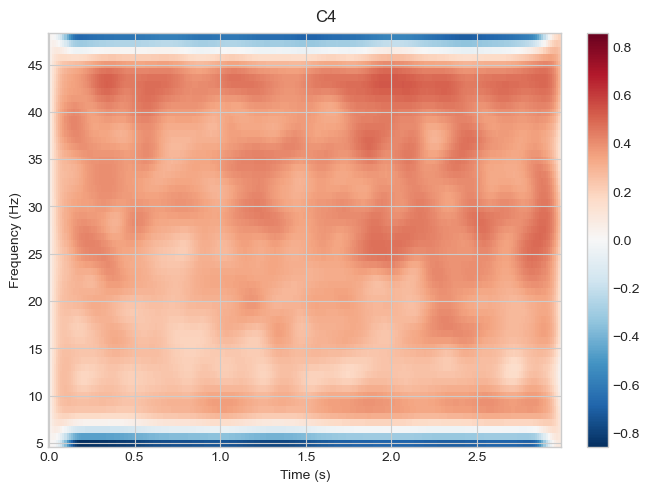

Applying baseline correction (mode: logratio)


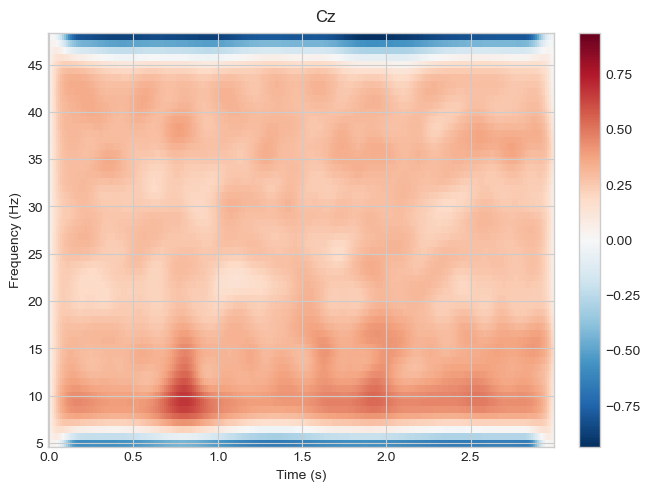

Applying baseline correction (mode: logratio)


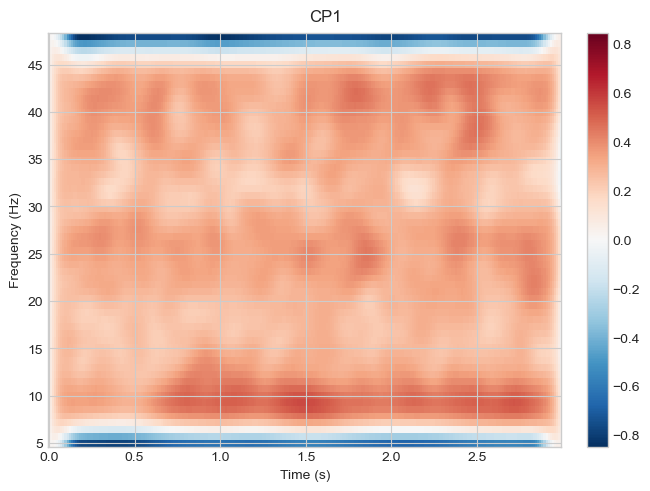

Applying baseline correction (mode: logratio)


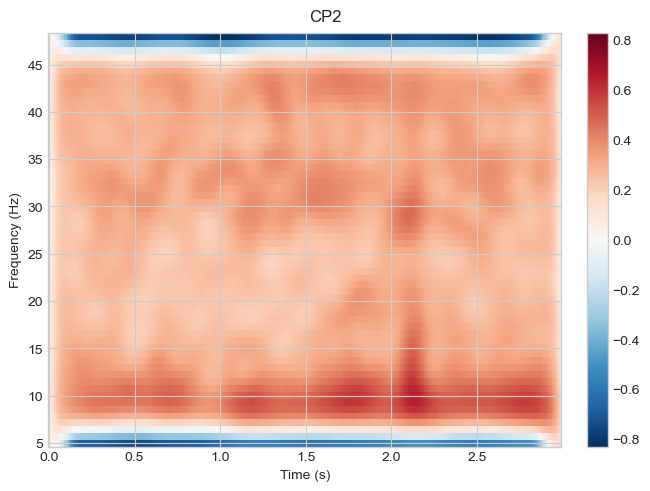

In [32]:
power.plot_topo(baseline=(-0.5, 0), fmin=5, fmax=48, mode="logratio", title="Average power")
list_elect = [c3,c4,cz,cp1,cp2]
for i in list_elect:
    power.plot([i], baseline=(-0.5, 0), fmin=5, fmax=48, mode="logratio", title=power.ch_names[i])
